# I. Importing Libraries & Modules

*************************************************************************************************************************************************************************************************************************************

**Basics**

In [62]:
import pandas as pd
import numpy as np

**OS & Directory Structuring**

In [63]:
import os
from os import makedirs
from os import listdir
from pathlib import Path

**Visuals**

In [64]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.interpolate import make_interp_spline
from IPython.display import Image, display

**SciKit-Learn Metrics & Modelings**

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

**Tensorflow & Keras**

In [66]:
import tensorflow as tensorflow

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Random**

In [67]:
import random
import shutil
from random import seed
from shutil import copyfile
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

**SEED**

In [68]:
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
tensorflow.random.set_seed(SEED)
tensorflow.keras.utils.set_random_seed(SEED)

### Google

In [69]:
import gdown
import zipfile
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# II. Extracting Compressed Datasets

In [70]:
archive_path = '/content/drive/MyDrive/Colab Notebooks/Dogs vs Cats/DVC Assets/dogs-vs-cats.zip'
extract_dir = '/content/Dogs vs Cats/DVC Assets'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(path=extract_dir)
print("Dog Vs. Cats folders & files extraction complete.")

Dog Vs. Cats folders & files extraction complete.


In [71]:
archive_path = '/content/Dogs vs Cats/DVC Assets/train.zip'
extract_dir = '/content/Dogs vs Cats/DVC Assets'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(path=extract_dir)
print("Training files extraction complete.")

Training files extraction complete.


In [72]:
archive_path = '/content/Dogs vs Cats/DVC Assets/test1.zip'
extract_dir = '/content/Dogs vs Cats/DVC Assets'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(path=extract_dir)
print("DVC Testing files extraction complete.")

DVC Testing files extraction complete.


*************************************************************************************************************************************************************************************************************************************

# III. Reading & Organizing Datafiles

*************************************************************************************************************************************************************************************************************************************

In [73]:
path = r'/content/Dogs vs Cats/DVC Assets/train'
path

'/content/Dogs vs Cats/DVC Assets/train'

***Creating a list of all files in the folder path that are either JPEG or PNG images***

In [74]:
img_list = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [75]:
img_list = []

for file in os.listdir(path):
    if file.endswith('.jpg') or file.endswith('.png'):
        img_list.append(file)

***Branding animal species to E\ensuring proper ratios of the two animal species sets***

In [76]:
labels = [0 if 'cat' in fname else 1 for fname in img_list]

In [77]:
len(img_list)

25000

*************************************************************************************************************************************************************************************************************************************

# IV. Preparing Data for Machine Learning

*************************************************************************************************************************************************************************************************************************************

*This function prepares image data for machine learning tasks in 7 steps by dividing it into three distinct sets, while preserving the class balance.*

**Steps:**

1. Defining Function and Related Preparation Parameters: ("path", "val_size", "test_size", "random_state")

2. Extracting Filenames and Categories: ("Dog" or not "Dog")

3. Creating Pandas DataFrame: ("pd.DataFrame")

4. Funneling Sets into Dataframes by employing train_test_split to Split Training and Temporary Sets: ("train_df", "temp_df")

5. Creating a Validation ratio ("val_ratio") for use in making a Validation DataFrame: ("val_df")

6. Splitting the Temporary Set into Validation and Test Sets: ("val_df", "test_df")

7. Returning the Split DataFrames: "train_df", "val_df", "test_df"


In [78]:
def prepare_data(path, val_size=0.20, test_size=0.20, random_state=4):

    train_filenames = os.listdir(path)
    train_categories = [1 if 'dog' in filename.lower() else 0 for filename in train_filenames]

    df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })


    train_df, temp_df = train_test_split(df, test_size=(val_size + test_size), stratify=df["category"], random_state=random_state)

    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_ratio), stratify=temp_df["category"], random_state=random_state)

    return train_df, val_df, test_df

*Ensuring correct split value counts*

In [79]:
train_df, val_df, test_df = prepare_data(path)
print(f"Total Training Images: {len(train_df)}")
print(f"Total Validation Images: {len(val_df)}")
print(f"Total Test Images: {len(test_df)}")

Total Training Images: 15000
Total Validation Images: 5000
Total Test Images: 5000


*************************************************************************************************************************************************************************************************************************************

# V. Creating, Defining & Organizing "Subsampled Dataset"

*************************************************************************************************************************************************************************************************************************************

**Subsampled Dataset**

*This function organizes an image subset from a source directory into category-specific subdirectories ("dogs" and "cats") within a specified base directory ("cats_vs_dogs"), using information from our Pandas DataFrame.*

*This is conducted in a **10-step** process:*

1. Defining overarching logical functions and parameters

2. Defining category directories for "Dogs" & "Cats": ("os.path.join")

3. Creating category directories for "Dogs" & "Cats": ("os.makedirs")

4. Setting the Source Path for the original images: (source_path)

5. Creating forloop that brands cats as 0 and dogs as 1 to iterate through their respective categories

6. Creating forloop to iterate through filenames for each category

7. Ensuring that source path for the original images ("src") actually exists, after step 4

8. ("dst") is a new directory structure with new brand filenames in "cats" & "dogs" folders

9. Copying "src" (source path) & "destination path" (dst) images with "shutil.copyfile" command

10. Creating & defining a new specified base directory ('base_dir"), which will be referenced momentarily

In [80]:
def subsampled_dataset(df, source_path, base_dir, dataset_type):
    dogs_dir = os.path.join(base_dir, dataset_type, "dogs")
    cats_dir = os.path.join(base_dir, dataset_type, "cats")
    os.makedirs(dogs_dir, exist_ok=True)
    os.makedirs(cats_dir, exist_ok=True)
    source_path = Path(source_path)

    for category, num, folder in [("cat", 0, cats_dir), ("dog", 1, dogs_dir)]:
        for i, filename in enumerate(df[df["category"] == num]["filename"]):
            src = source_path / filename
            if not src.exists():
                print(f"Warning: {src} does not exist!")
                continue
            dst = os.path.join(folder, f"{category}{i}.jpg")
            shutil.copyfile(src, dst)

base_dir = "cats_vs_dogs"

*************************************************************************************************************************************************************************************************************************************

### Creating Binary Target Directories from subsampled datasets

Calling 3 functions that takes a Pandas DataFrame (df), a source path (source_path), a base directory (base_dir), and a dataset type as inputs; each line contains a different dataset type ("train", "test", and "validation").

The overall purpose is to copy image files from the source directory & create organized 2 target directories based on their categories ("cats" and "dogs").

*Sidenote: As previously defined in the above function, if any source_path file doesn’t actually exist, a warning is generated and the file will be skipped.*

In [81]:
subsampled_dataset(test_df, path, base_dir, "test")

In [82]:
subsampled_dataset(train_df, path, base_dir, "train")

In [83]:
subsampled_dataset(val_df, path, base_dir, "validation")

*************************************************************************************************************************************************************************************************************************************

*************************************************************************************************************************************************************************************************************************************

# VI. Data Preprocessing

*************************************************************************************************************************************************************************************************************************************

**Differentiating Directory names**

*"base_dir" specifies the directory containing the training images*

*"new_base_dir" is a Path object version of the base directory string, providing more powerful ways to work with original "base_dir" path*

In [84]:
new_base_dir = Path(base_dir)

**Training Dataset**

*"image_dataset_from_directory" is a TensorFlow/Keras utility that loads image data from a directory structure. It automatically infers class labels from the subdirectory names within the specified directory.*

*"new_base_dir" is assumed to be a Path object (from the pathlib library) or a string representing the base directory.*

*"/train" appends the "train" subdirectory to the base path, indicating that the training images are located within a folder named "train" inside the new_base_dir.*

*The directory structure is expected to be organized such that each subdirectory within "train" represents a different class, and the images within each subdirectory belong to that class.*

*"batch_size=64":
This specifies that the dataset should be divided into batches of 64 images. During training, the model processes these batches of 32 images at a time. This is done for memory efficiency and to improve training speed.*

*"shuffle=True":
This shuffles the order of the images in the dataset. Shuffling is important to prevent the model from learning any biases related to the order of the data. It ensures that each batch contains a random selection of images.*

In [85]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64,
    shuffle=True,
    seed=4
)

Found 15000 files belonging to 2 classes.


**Validation Dataset**

In [86]:
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64,
    shuffle=True,
    seed=4
)

Found 5000 files belonging to 2 classes.


**Test Dataset**

In [87]:
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64,
    shuffle=True,
    seed=4
)

Found 5000 files belonging to 2 classes.


In [88]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


*************************************************************************************************************************************************************************************************************************************

# VII. Custom Tf.Keras CNN Modeling with Accuracy & Loss Evaluations

*************************************************************************************************************************************************************************************************************************************

In [89]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

**Input Layers**

In [90]:
inputs = keras.Input(shape=(180, 180, 3))

**Conv Block 1**

In [91]:
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

**Conv Block 2**

In [92]:
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

**Conv Block 3**

In [93]:
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

**Conv Block 4**

*The number of convolution block filters usually increase as we go deeper, because deeper layers learn more complex features - but at the cost of more parameters and longer training.*

In [94]:
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

**Flatten Layer**

In [95]:
x = layers.Flatten()(x)

**Dropout Layer**

In [96]:
x = layers.Dropout(0.5)(x)

**Outputs**

In [97]:
outputs = layers.Dense(1, activation="sigmoid")(x)

*************************************************************************************************************************************************************************************************************************************

**Compile**

*Specifically employing "binary_crossentropy" in compiling our model, because our task is binary classification ("cats" & "dogs")*

In [98]:
model = keras.Model(inputs, outputs)

adamw_optimizer = AdamW(
    learning_rate=0.00050,
    weight_decay=1e-3
)

model.compile(
    loss="binary_crossentropy",
    optimizer=adamw_optimizer,
    metrics=["accuracy"]
)

**Callbacks**

***EarlyStopping*** → *stops training when validation loss stops improving, so it doesn’t start going up*

***ReduceLROnPlateau*** → *lowers the learning rate ***automatically*** if validation loss stops getting better*

***Increased epochs*** → *training for more epochs is fine because EarlyStopping will stop it at the right time*

***Weight decay*** = *1e-3 → helps the model avoid overfitting without making it too simple*

***ModelCheckpoint*** → *automatically saves the model with the best validation loss*

In [99]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=1,
    min_lr=1e-3,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss",
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

**Fitting #1: Tensorflow-Keras Model**

*Training time: roughly 20 minutes using NVIDIA Tesla T4 GPU - provided by Google*

In [100]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

model.save("/content/convnet_from_scratch.keras")
print("✅ CNN model saved successfully as convnet_from_scratch.keras")

Epoch 1/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5653 - loss: 0.6713
Epoch 1: val_loss improved from inf to 0.56256, saving model to convnet_from_scratch.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.5658 - loss: 0.6710 - val_accuracy: 0.7128 - val_loss: 0.5626 - learning_rate: 5.0000e-04
Epoch 2/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7097 - loss: 0.5625
Epoch 2: val_loss improved from 0.56256 to 0.52967, saving model to convnet_from_scratch.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.7097 - loss: 0.5624 - val_accuracy: 0.7372 - val_loss: 0.5297 - learning_rate: 5.0000e-04
Epoch 3/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7423 - loss: 0.5202
Epoch 3: val_loss improved from 0.52967 to 0.50560, saving model to convnet_from_scratch.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.7424 - loss: 0.5201 - val_accuracy: 0.7514 - val_loss: 0.5056 - learning_rate: 5.0000e-04
Epoch 4/30
234/2

**Summary**

In [101]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        20,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,227,461 (4.68 MB)

 Trainable params: 409,153 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 818,308 (3.12 MB)

*************************************************************************************************************************************************************************************************************************************

### Organizing CNN Graphs

In [102]:
epochs = list(range(1, len(history.history['loss']) + 1))
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_np = np.array(epochs)
accuracy_np = np.array(accuracy) * 100
val_accuracy_np = np.array(val_accuracy) * 100

if len(epochs_np) >= 4:
    epochs_smooth = np.linspace(epochs_np.min(), epochs_np.max(), 500)
    spl_acc = make_interp_spline(epochs_np, accuracy_np, k=3)
    spl_val_acc = make_interp_spline(epochs_np, val_accuracy_np, k=3)
    accuracy_smooth = spl_acc(epochs_smooth)
    val_accuracy_smooth = spl_val_acc(epochs_smooth)
else:
    epochs_smooth = epochs_np
    accuracy_smooth = accuracy_np
    val_accuracy_smooth = val_accuracy_np

### Plotting Accuracy & Loss Graphs for Convolutional Neural Network

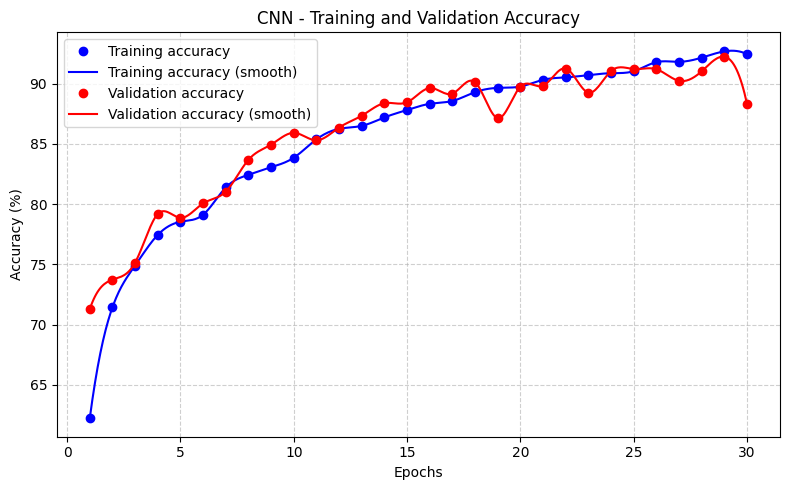

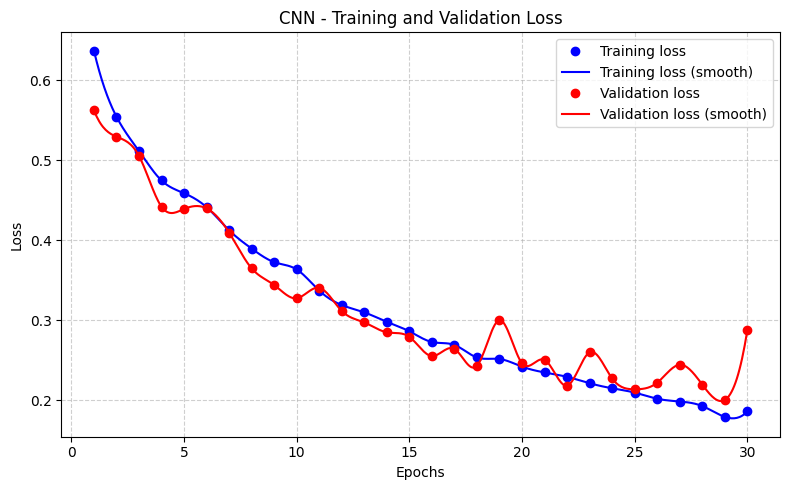

In [103]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_np, accuracy_np, "bo", label="Training accuracy")
plt.plot(epochs_smooth, accuracy_smooth, "b-", label="Training accuracy (smooth)")
plt.plot(epochs_np, val_accuracy_np, "ro", label="Validation accuracy")
plt.plot(epochs_smooth, val_accuracy_smooth, "r-", label="Validation accuracy (smooth)")
plt.title("CNN - Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

loss_np = np.array(loss)
val_loss_np = np.array(val_loss)

if len(epochs_np) >= 4:
    spl_loss = make_interp_spline(epochs_np, loss_np, k=3)
    spl_val_loss = make_interp_spline(epochs_np, val_loss_np, k=3)
    loss_smooth = spl_loss(epochs_smooth)
    val_loss_smooth = spl_val_loss(epochs_smooth)
else:
    loss_smooth = loss_np
    val_loss_smooth = val_loss_np

plt.figure(figsize=(8, 5))
plt.plot(epochs_np, loss_np, "bo", label="Training loss")
plt.plot(epochs_smooth, loss_smooth, "b-", label="Training loss (smooth)")
plt.plot(epochs_np, val_loss_np, "ro", label="Validation loss")
plt.plot(epochs_smooth, val_loss_smooth, "r-", label="Validation loss (smooth)")
plt.title("CNN - Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

*************************************************************************************************************************************************************************************************************************************

### Sanity Check

In [104]:
base_dir = "cats_vs_dogs"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

print("\n📂 Subsampled dataset check:")
for split in ['train', 'validation', 'test']:
    cats_path = os.path.join(base_dir, split, 'cats')
    dogs_path = os.path.join(base_dir, split, 'dogs')

    if os.path.exists(cats_path) and os.path.exists(dogs_path):
        print(f"{split.title()} - Cats: {len(os.listdir(cats_path))}, Dogs: {len(os.listdir(dogs_path))}")
    else:
        print(f"{split.title()} directories not found.")


print("\n🔬 Inspecting test directory and inferred class names:")
test_dir_path = Path(base_dir) / "test"

if os.path.exists(test_dir_path):
    print(f"Contents of {test_dir_path}: {os.listdir(test_dir_path)[:10]}...")
    try:
        test_dataset = tensorflow.keras.utils.image_dataset_from_directory(
            test_dir_path,
            image_size=(180, 180),
            batch_size=64,
            shuffle=False,
            labels='inferred'
        )
        print(f"Inferred class names: {test_dataset.class_names}")
        if len(test_dataset.class_names) != 2:
            print(f"\n⚠️ Expected 2 classes, but found {len(test_dataset.class_names)}. Check directory structure.")
            test_dataset = None
    except Exception as e:
        print(f"Error creating test_dataset: {e}")
        test_dataset = None
else:
    print(f"Test directory not found at {test_dir_path}")
    test_dataset = None


dog_count = 0
cat_count = 0

if test_dataset is not None and len(test_dataset.class_names) == 2:
    for images, labels in test_dataset:
        dog_count += (labels.numpy() == 1).sum()
        cat_count += (labels.numpy() == 0).sum()

    print("\n🧪 TensorFlow test dataset label distribution:")
    print(f"TF Test Dataset - Cats: {cat_count}, Dogs: {dog_count}")

    from tensorflow.keras.models import load_model

    model_path = "convnet_from_scratch.keras"
    if os.path.exists(model_path):
        model = load_model(model_path)

        print("\n🔍 Sample raw predictions:")
        for images, labels in test_dataset.take(1):
            preds = model.predict(images).flatten()
            print("Raw predictions:", preds[:20])
            print("Predicted classes:", (preds > 0.5).astype(int)[:20])
            print("True classes:", labels.numpy()[:20])
    else:
        print(f"\n⚠️ Model file not found at {model_path}. Skipping predictions.")
else:
    print("\n Skipping dataset iteration and predictions due to error creating test_dataset or incorrect number of classes.")


📂 Subsampled dataset check:
Train - Cats: 7500, Dogs: 7500
Validation - Cats: 2500, Dogs: 2500
Test - Cats: 2500, Dogs: 2500

🔬 Inspecting test directory and inferred class names:
Contents of cats_vs_dogs/test: ['dogs', 'cats']...
Found 5000 files belonging to 2 classes.
Inferred class names: ['cats', 'dogs']

🧪 TensorFlow test dataset label distribution:
TF Test Dataset - Cats: 2500, Dogs: 2500

🔍 Sample raw predictions:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
Raw predictions: [7.9294033e-03 9.7772729e-01 1.9793522e-01 4.5019782e-01 2.8045624e-02
 6.4561968e-03 1.1831846e-03 9.9163599e-02 4.4103161e-01 1.6044649e-05
 1.6140860e-02 3.9143679e-01 4.3336517e-04 1.9980301e-01 9.9349856e-02
 3.9494250e-02 7.2450528e-04 8.2546077e-04 9.4736060e-03 4.3969344e-02]
Predicted classes: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [105]:
from tensorflow import keras

model = keras.models.load_model("/content/convnet_from_scratch.keras")

preds = model.predict(test_dataset)
predicted_classes = (preds > 0.5).astype("int32").flatten()

print("First 20 predicted classes:", predicted_classes[:20])

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
First 20 predicted classes: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


*************************************************************************************************************************************************************************************************************************************

# VIII. Transfer Learning "VGG16 Model" (Feature Extraction with Data Augmentation)

*************************************************************************************************************************************************************************************************************************************

In [106]:
from tensorflow.keras.applications.vgg16 import VGG16

*This code block loads the VGG16 model, removing its classification head, and prepares it to receive images of size 180x180x3.*

**Loading VGG Model**

In [107]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Architecture Summary Display:**

Layer Type

Output Shape

Total Params

Trainable Params

Non-Trainable Params

In [108]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Non-trainable params:**

*This line of code, conv_base.trainable = False, is used in the context of transfer learning from pre-trained models in Keras (and TensorFlow).*

In [109]:
conv_base.trainable = False

**Inputs**

In [110]:
inputs = keras.Input(shape=(180, 180, 3))

**Data Augmentation**

In [111]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ])

x = data_augmentation(inputs)

**Preprocessing Input:**

*Channel Order*

*Pixel Value Normalization*

In [112]:
x = keras.applications.vgg16.preprocess_input(x)

**Conv Block 1**

In [113]:
x = conv_base(x)

**Flatten Layer**

In [114]:
x = layers.Flatten()(x)

**Dense Layer**

In [115]:
x = layers.Dense(256, activation="relu")(x)

**Dropout Layer**

In [116]:
x = layers.Dropout(0.5)(x)

**Output Layers**

In [117]:
outputs = layers.Dense(1, activation="sigmoid")(x)

**Defining Model Architecture**

In [118]:
model3 = keras.Model(inputs, outputs)

**Compile**

In [119]:
model3.compile(
    loss="binary_crossentropy",
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-3),
    metrics=["accuracy"]
)

**Callbacks**

In [120]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
 ]

**VGG-16 Model**

*(*Training time: approx. 30 minutes using NVIDIA Tesla T4 GPU - provided by Google)**

*The training set's purpose is to allow the machine learning algorithm to identify patterns, relationships, and trends within the data.*

*By analyzing the training data, the model adjusts its internal parameters to make accurate predictions or classifications.*

*"epoch" refers to one complete pass of the entire training dataset through the learning algorithm*

*"Validation Dataset" is used to evaluate the model during training and to tune hyperparameters.*

In [121]:
history = model3.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

model.save("/content/feature_extraction_with_data_augmentation.keras")
print("✅ VGG-16 model saved successfully as feature_extraction_with_data_augmentation.keras")

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 61s 252ms/step - accuracy: 0.8779 - loss: 1.4907 - val_accuracy: 0.9736 - val_loss: 0.1909
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.9495 - loss: 0.2698 - val_accuracy: 0.9758 - val_loss: 0.1167
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 243ms/step - accuracy: 0.9560 - loss: 0.1435 - val_accuracy: 0.9752 - val_loss: 0.0922
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 245ms/step - accuracy: 0.9639 - loss: 0.1072 - val_accuracy: 0.9778 - val_loss: 0.0804
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 269ms/step - accuracy: 0.9646 - loss: 0.0972 - val_accuracy: 0.9764 - val_loss: 0.0806
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 246ms/step - accuracy: 0.9669 - loss: 0.0857 - val_accuracy: 0.9782 - val_loss: 0.0716
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 64s 271ms/step - accuracy: 0.9730 - loss: 0.0756 - val_accuracy: 0.9780 - val_loss: 0.0716
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 76s 246ms/step - accuracy: 0.9747 - loss: 0

*************************************************************************************************************************************************************************************************************************************

**VGG-16 Accuracy and Validation Loss (Training Set)**

In [ ]:
epochs = list(range(1, len(history.history['loss']) + 1))
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_np = np.array(epochs)
accuracy_np = np.array(accuracy) * 100
val_accuracy_np = np.array(val_accuracy) * 100

if len(epochs_np) >= 4:
    epochs_smooth = np.linspace(epochs_np.min(), epochs_np.max(), 500)
    spl_acc = make_interp_spline(epochs_np, accuracy_np, k=3)
    spl_val_acc = make_interp_spline(epochs_np, val_accuracy_np, k=3)
    accuracy_smooth = spl_acc(epochs_smooth)
    val_accuracy_smooth = spl_val_acc(epochs_smooth)
else:
    epochs_smooth = epochs_np
    accuracy_smooth = accuracy_np
    val_accuracy_smooth = val_accuracy_np

plt.figure(figsize=(8, 5))
plt.plot(epochs_np, accuracy_np, "bo", label="Training accuracy")
plt.plot(epochs_smooth, accuracy_smooth, "b-", label="Training accuracy (smooth)")
plt.plot(epochs_np, val_accuracy_np, "ro", label="Validation accuracy")
plt.plot(epochs_smooth, val_accuracy_smooth, "r-", label="Validation accuracy (smooth)")

plt.title("VGG16 - Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

*************************************************************************************************************************************************************************************************************************************

**Test Dataset Evaluation**

In [131]:
from tensorflow.keras.models import load_model
import os

model_path = "/content/feature_extraction_with_data_augmentation.keras"

print("✅ test_dataset:", test_dataset)
print("✅ Classes:", test_dataset.class_names)
print("📁 Model exists:", os.path.exists(model_path))

# Try loading model
try:
    model = load_model(model_path)
    print("✅ Model loaded successfully")
except Exception as e:
    print("❌ Model failed to load:", e)

# Try evaluating model
try:
    print("📊 Starting test evaluation...")
    test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
    print("✅ Evaluation complete!")
    print(f"📉 Test Loss: {test_loss:.4f}")
    print(f"📈 Test Accuracy: {test_acc * 100:.2f}%")
except Exception as e:
    print("❌ Evaluation failed:", e)


✅ test_dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
✅ Classes: ['cats', 'dogs']
📁 Model exists: True
✅ Model loaded successfully
📊 Starting test evaluation...
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9007 - loss: 0.2419
✅ Evaluation complete!
📉 Test Loss: 0.1890
📈 Test Accuracy: 92.52%


*************************************************************************************************************************************************************************************************************************************

 # IX. Evaluation/Conclusions: ROC/AUC & F1 SCORES, Classification Report, etc.

*************************************************************************************************************************************************************************************************************************************

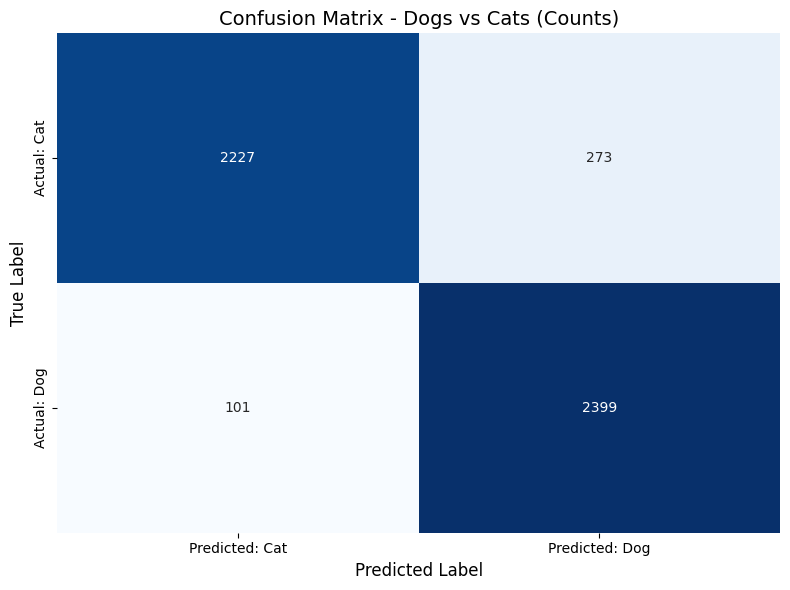

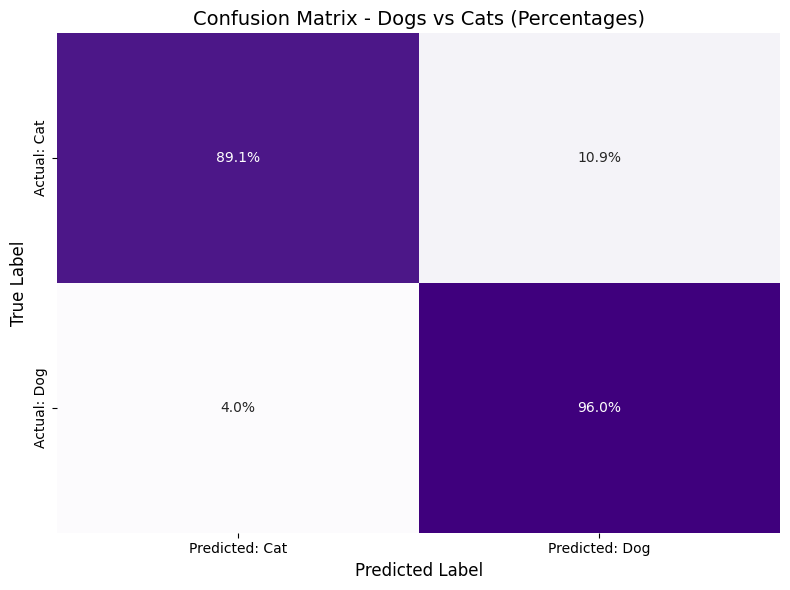


📊 Classification Report:
              precision    recall  f1-score   support

         Cat     0.9566    0.8908    0.9225      2500
         Dog     0.8978    0.9596    0.9277      2500

    accuracy                         0.9252      5000
   macro avg     0.9272    0.9252    0.9251      5000
weighted avg     0.9272    0.9252    0.9251      5000



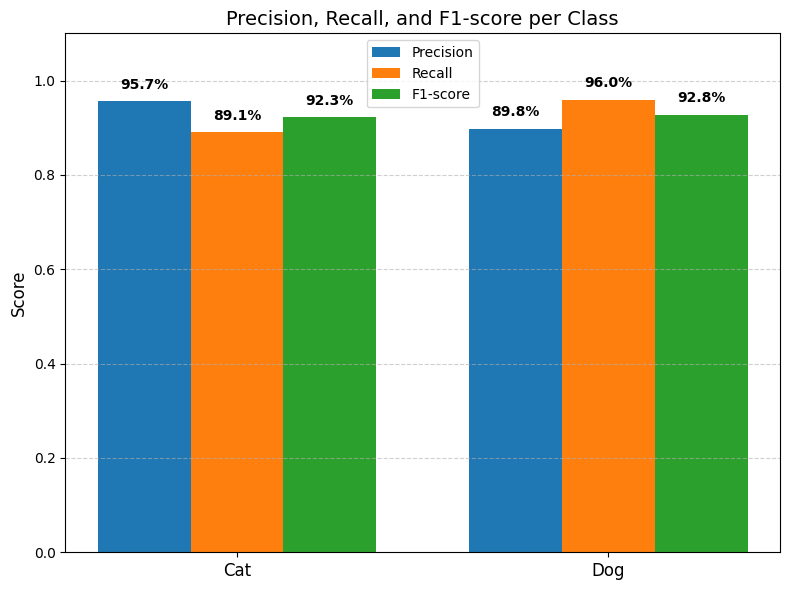


📊 Per-Class Metrics:
Cat   | Precision: 0.9566 | Recall: 0.8908 | F1-score: 0.9225
Dog   | Precision: 0.8978 | Recall: 0.9596 | F1-score: 0.9277


In [134]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = ["Cat", "Dog"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=[f"Predicted: {c}" for c in class_names],
    yticklabels=[f"Actual: {c}" for c in class_names]
)

plt.title("Confusion Matrix - Dogs vs Cats (Counts)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_norm * 100
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap='Purples',
    cbar=False,
    xticklabels=[f"Predicted: {c}" for c in class_names],
    yticklabels=[f"Actual: {c}" for c in class_names]
)
plt.title("Confusion Matrix - Dogs vs Cats (Percentages)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for text in plt.gca().texts:
    text.set_text(f"{float(text.get_text()):.1f}%")

plt.tight_layout()
plt.show()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1])

metrics_df = {
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(8, 6))
bars_precision = plt.bar(x - width, precision, width, label="Precision")
bars_recall = plt.bar(x, recall, width, label="Recall")
bars_f1 = plt.bar(x + width, f1, width, label="F1-score")

plt.xticks(x, class_names, fontsize=12)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=12)
plt.title("Precision, Recall, and F1-score per Class", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bars in [bars_precision, bars_recall, bars_f1]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height * 100:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.tight_layout()
plt.show()

print("\n📊 Per-Class Metrics:")
for cls, p, r, f in zip(class_names, precision, recall, f1):
    print(f"{cls:<5} | Precision: {p:.4f} | Recall: {r:.4f} | F1-score: {f:.4f}")

*************************************************************************************************************************************************************************************************************************************

### ROC Curve

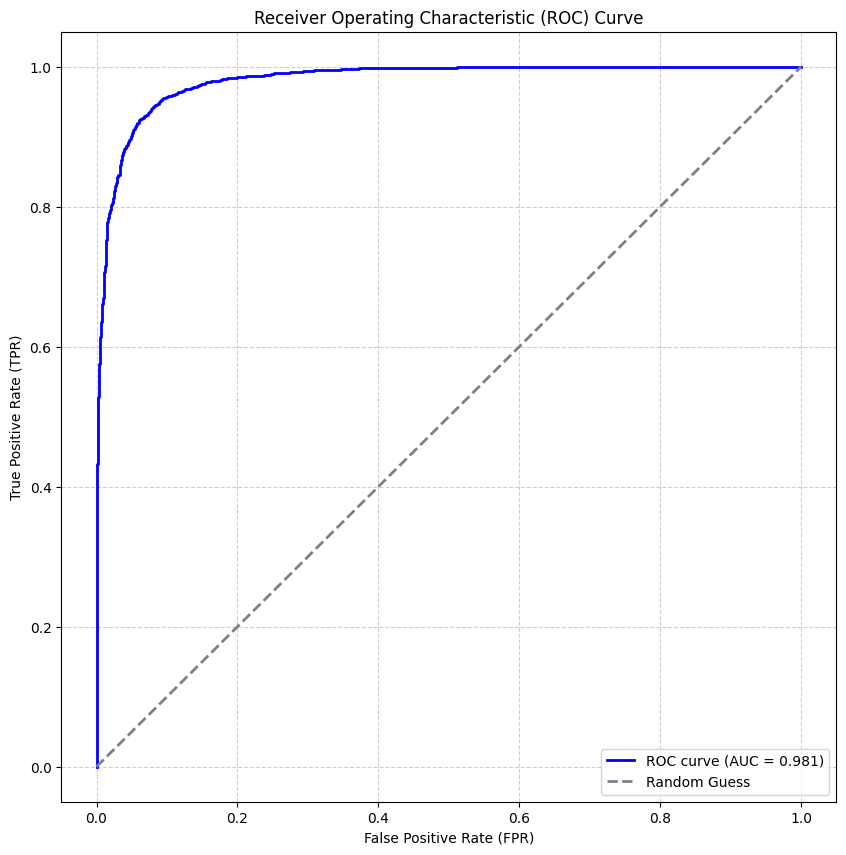

In [123]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Precision-Recall Curve

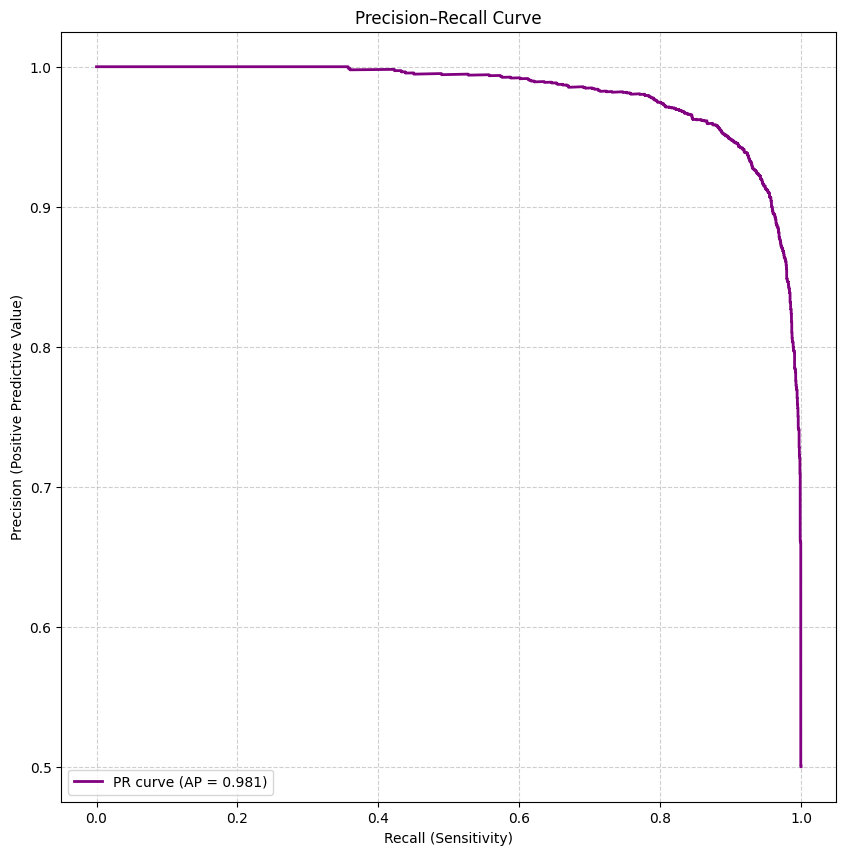

In [124]:
plt.figure(figsize=(10,10))
plt.plot(recall_vals, precision_vals, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (Positive Predictive Value)")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

*************************************************************************************************************************************************************************************************************************************